* Капустин Яромир
* 29.01.2023
* v0.1

# ДЗ 25
 
#### Для произвольно выбранного датасета провести обработку данных и построить предсказательную модель с использованием функционала pySpark.

In [7]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
mySpark = SparkSession.builder.getOrCreate()
spark = SparkSession(mySpark)

In [9]:
df = spark.read.csv('winequality-red.csv', inferSchema="true", header="true", sep =';')

In [10]:
df.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



In [11]:
df.count()

1599

In [12]:
df.show(10, truncate=True)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|            0.28|       0.56|           1.9|    0.075|               17.0|           

In [13]:
df.show(1, truncate=True, vertical = True)

-RECORD 0----------------------
 fixed acidity        | 7.4    
 volatile acidity     | 0.7    
 citric acid          | 0.0    
 residual sugar       | 1.9    
 chlorides            | 0.076  
 free sulfur dioxide  | 11.0   
 total sulfur dioxide | 34.0   
 density              | 0.9978 
 pH                   | 3.51   
 sulphates            | 0.56   
 alcohol              | 9.4    
 quality              | 5      
only showing top 1 row



### Чистка датасета

In [14]:
df.dropna()

DataFrame[fixed acidity: double, volatile acidity: double, citric acid: double, residual sugar: double, chlorides: double, free sulfur dioxide: double, total sulfur dioxide: double, density: double, pH: double, sulphates: double, alcohol: double, quality: int]

In [15]:
df.count()

1599

> нет нулевых значений

In [16]:
df.dropDuplicates()

DataFrame[fixed acidity: double, volatile acidity: double, citric acid: double, residual sugar: double, chlorides: double, free sulfur dioxide: double, total sulfur dioxide: double, density: double, pH: double, sulphates: double, alcohol: double, quality: int]

In [17]:
df.count()

1599

> дубликатов тоже нет

### Анализ датасета

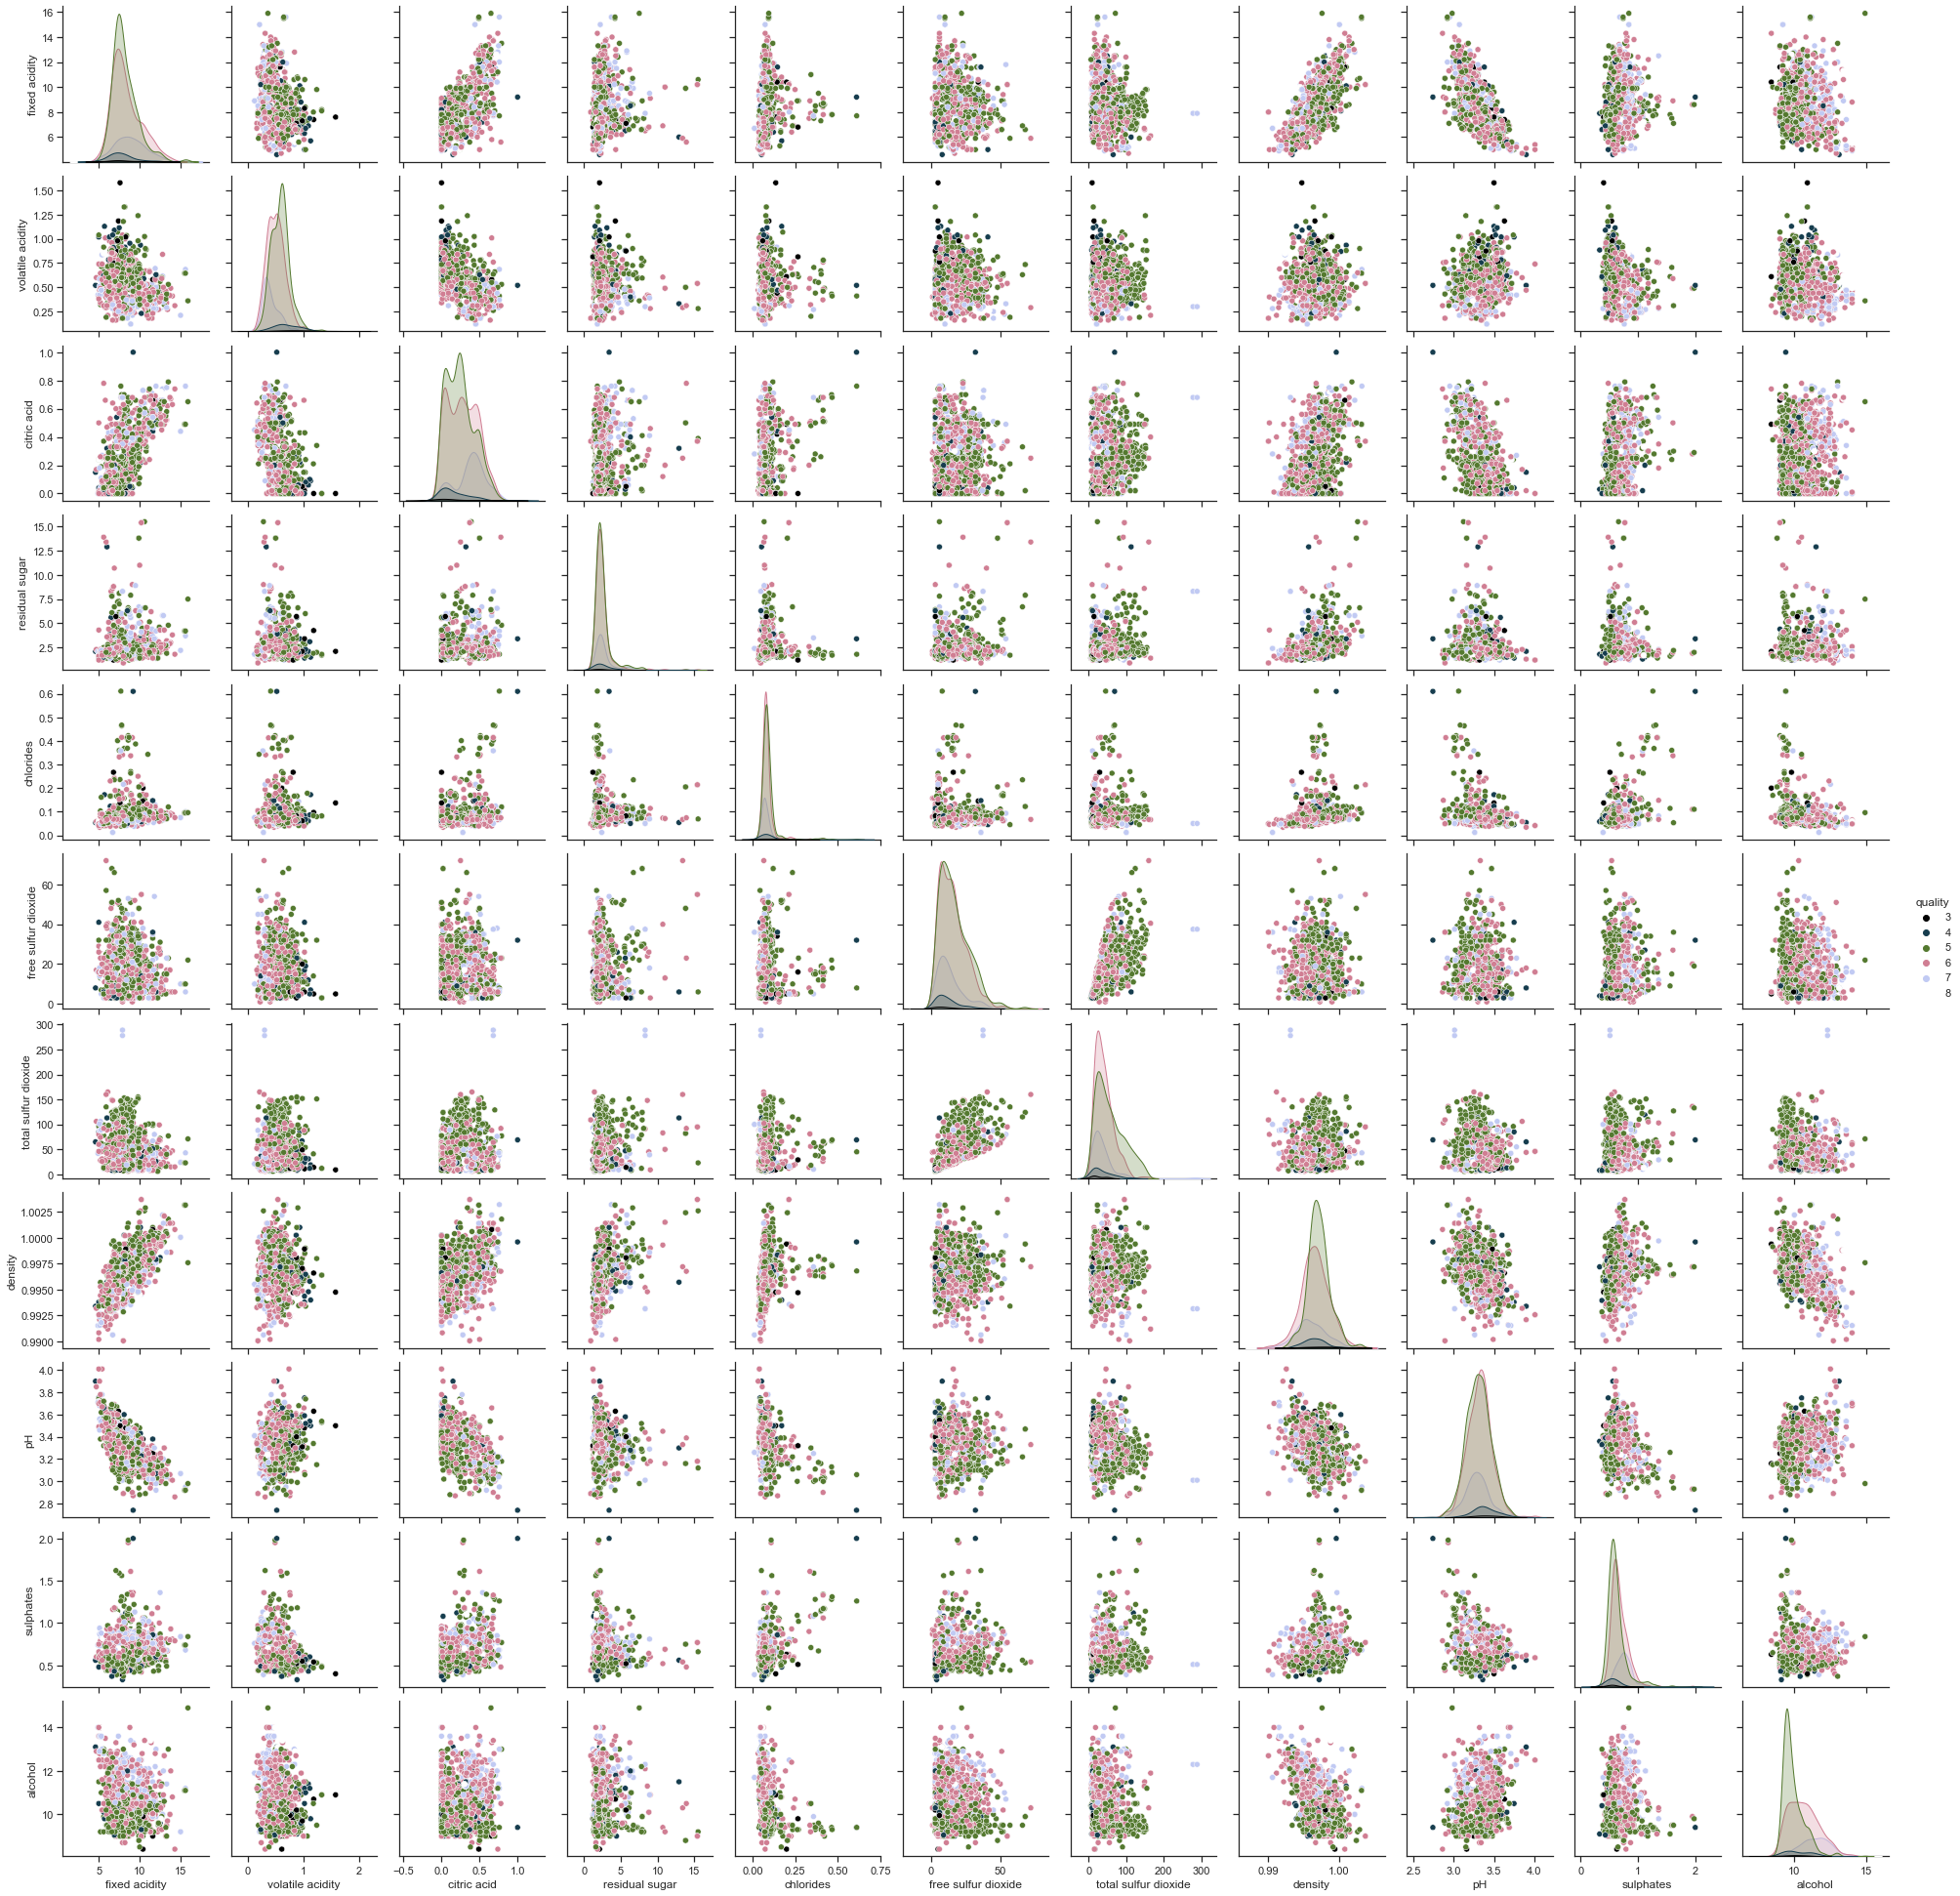

In [18]:
#аномальных значений нет
sns.set(style="ticks")

sns.pairplot(df.toPandas(), hue='quality', palette='cubehelix')
plt.show()

<AxesSubplot:xlabel='fixed acidity', ylabel='quality'>

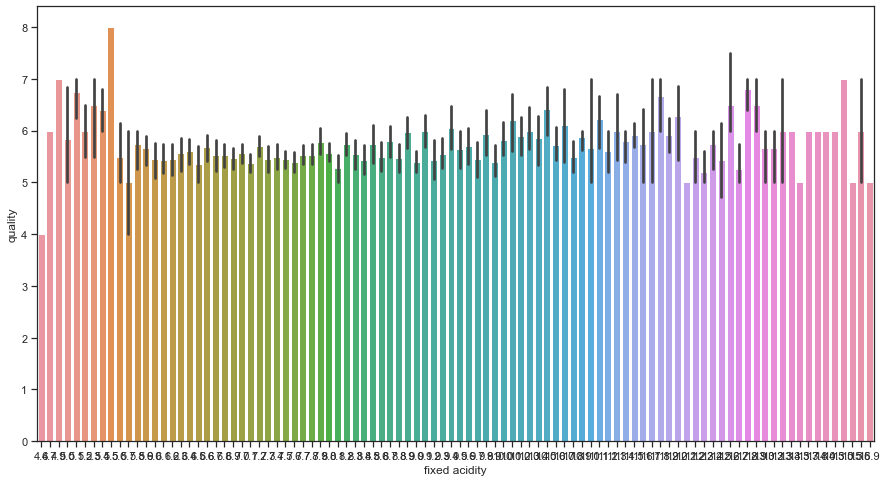

In [19]:
plt.subplots(figsize = (15,8)) 
sns.barplot(x="fixed acidity", y = "quality", data = df.toPandas())

<AxesSubplot:xlabel='volatile acidity', ylabel='quality'>

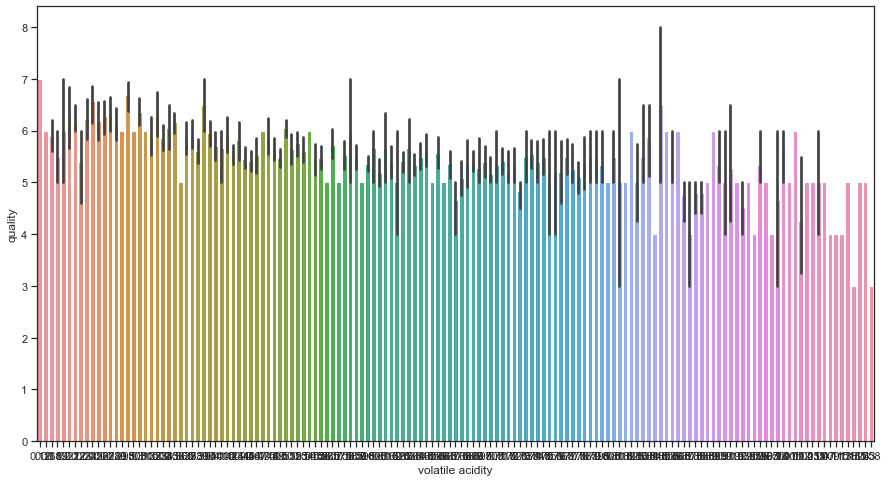

In [20]:
plt.subplots(figsize = (15,8)) 
sns.barplot(x="volatile acidity", y = "quality", data = df.toPandas())

<AxesSubplot:xlabel='citric acid', ylabel='quality'>

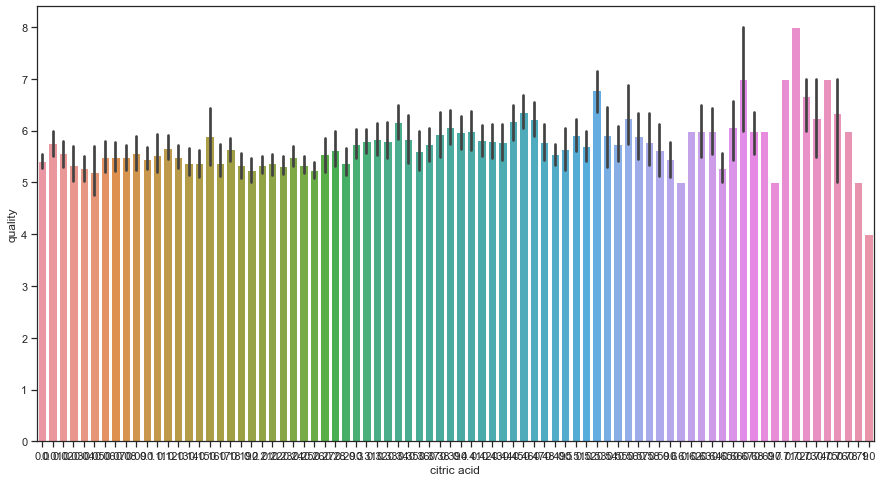

In [21]:
plt.subplots(figsize = (15,8)) 
sns.barplot(x="citric acid", y = "quality", data = df.toPandas())

<AxesSubplot:xlabel='residual sugar', ylabel='quality'>

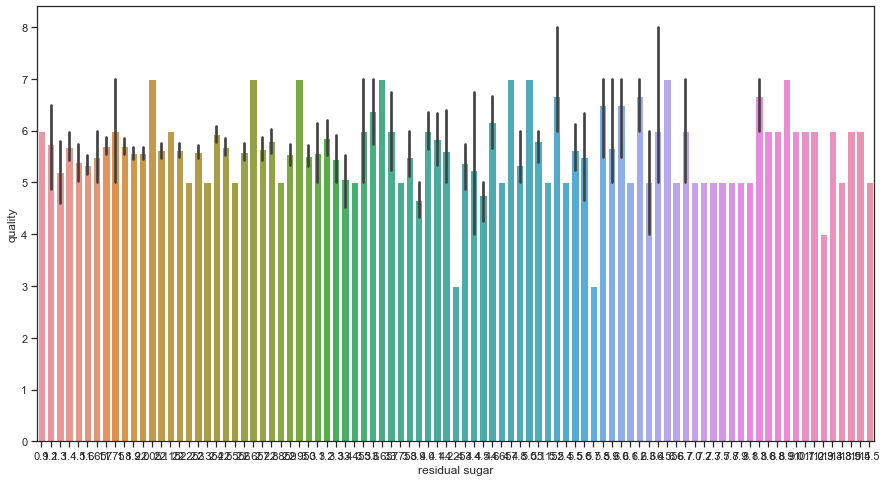

In [22]:
plt.subplots(figsize = (15,8)) 
sns.barplot(x="residual sugar", y = "quality", data = df.toPandas())

<AxesSubplot:xlabel='chlorides', ylabel='quality'>

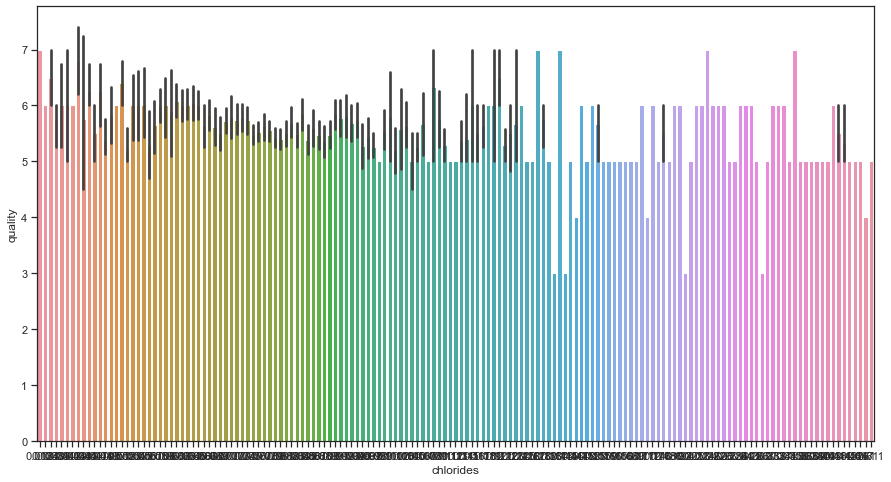

In [23]:
plt.subplots(figsize = (15,8)) 
sns.barplot(x="chlorides", y = "quality", data = df.toPandas())

<AxesSubplot:xlabel='free sulfur dioxide', ylabel='quality'>

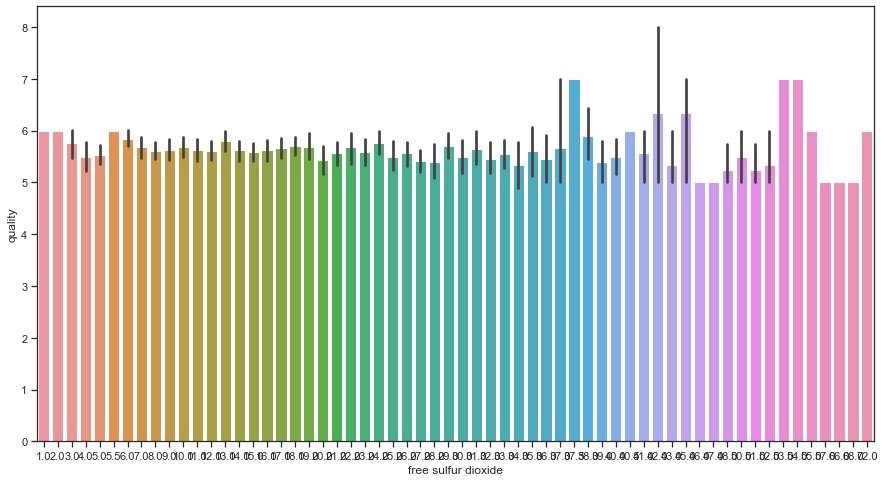

In [24]:
plt.subplots(figsize = (15,8)) 
sns.barplot(x="free sulfur dioxide", y = "quality", data = df.toPandas())

<AxesSubplot:xlabel='total sulfur dioxide', ylabel='quality'>

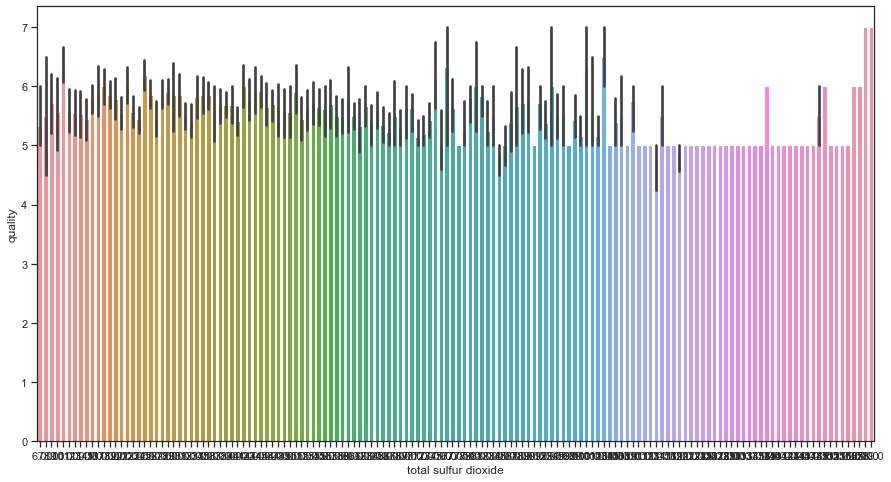

In [25]:
plt.subplots(figsize = (15,8)) 
sns.barplot(x="total sulfur dioxide", y = "quality", data = df.toPandas())

<AxesSubplot:xlabel='density', ylabel='quality'>

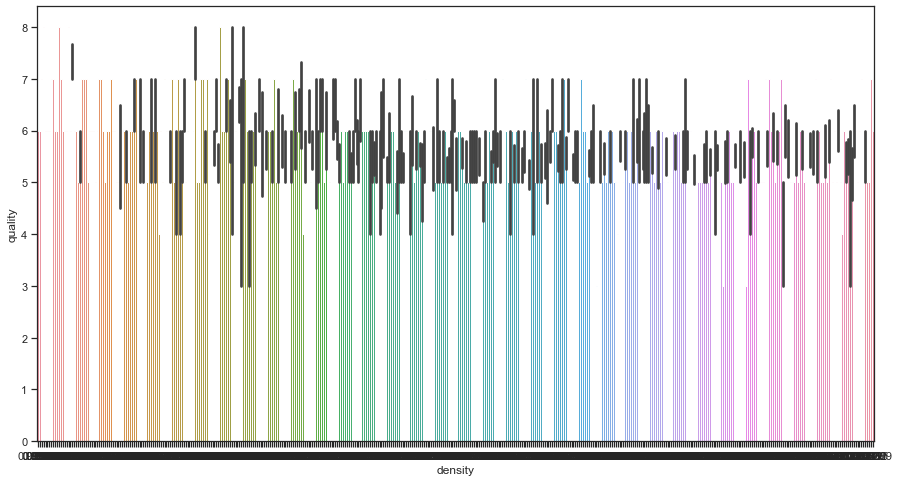

In [26]:
plt.subplots(figsize = (15,8)) 
sns.barplot(x="density", y = "quality", data = df.toPandas())

<AxesSubplot:xlabel='pH', ylabel='quality'>

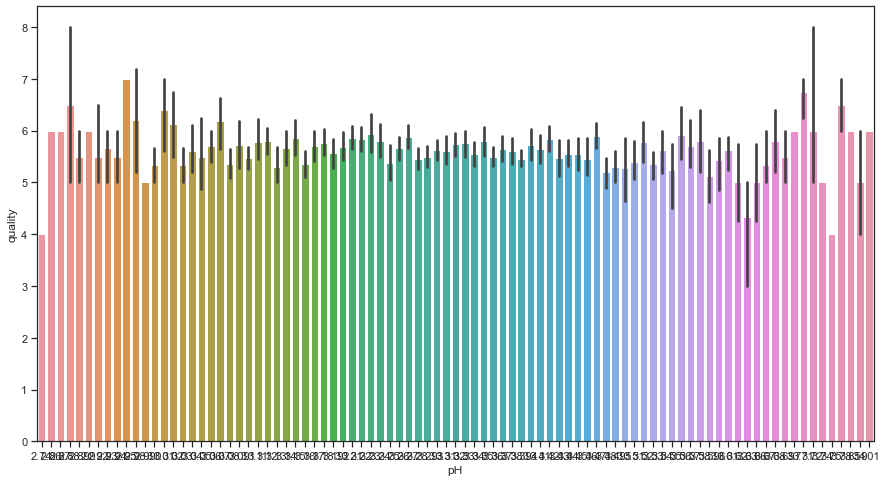

In [27]:
plt.subplots(figsize = (15,8)) 
sns.barplot(x="pH", y = "quality", data = df.toPandas())

<AxesSubplot:xlabel='sulphates', ylabel='quality'>

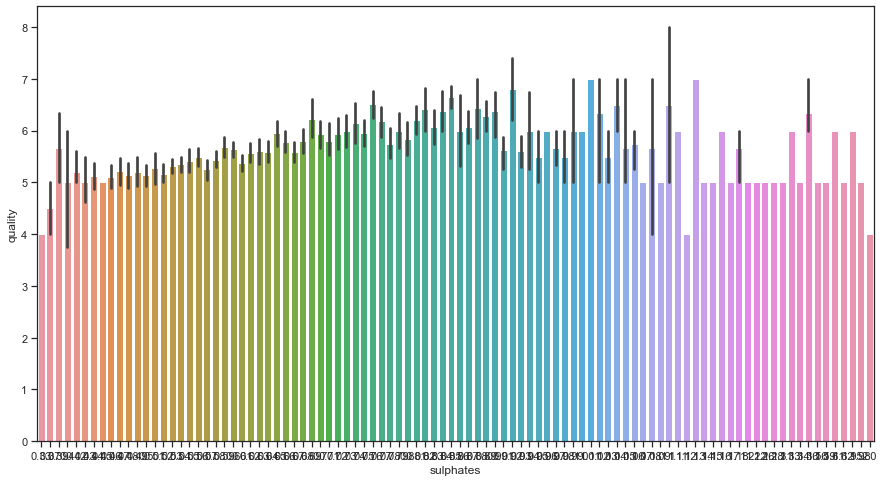

In [28]:
plt.subplots(figsize = (15,8)) 
sns.barplot(x="sulphates", y = "quality", data = df.toPandas())

<AxesSubplot:xlabel='alcohol', ylabel='quality'>

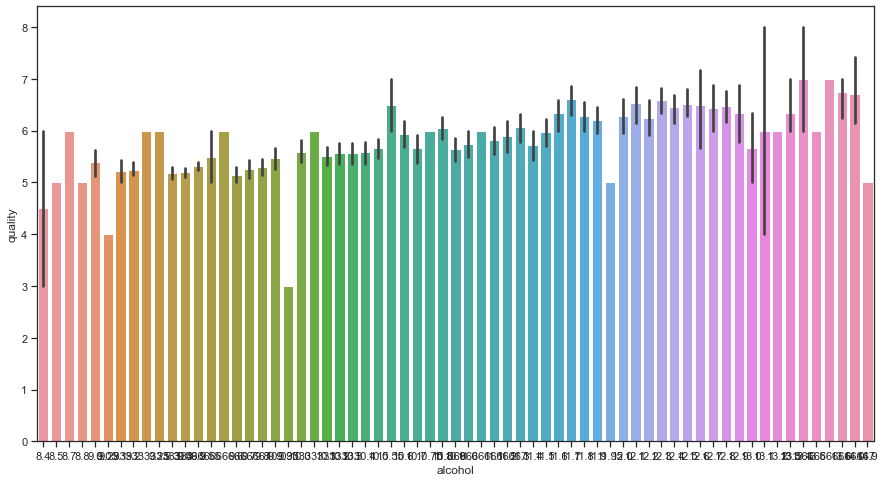

In [29]:
plt.subplots(figsize = (15,8)) 
sns.barplot(x="alcohol", y = "quality", data = df.toPandas())

### Наблюдения

1. вина с низкой фиксированной и летучей кислотностью имеют лучше оценку
2. вина с большим количеством лимонной кислоты имеют лучше оценку
3. вина со средними значениями количества сульфатов имеют лучше оценку
4. по мере возрастания крепости вина, оценка лучше


### Создание модели и прогноз

In [30]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

numericCols = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
               'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH','sulphates',
               'alcohol']
stages = []
label_stringIdx = StringIndexer(inputCol = 'quality', outputCol = 'label')
stages += [label_stringIdx]
assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="Subscribed")
stages += [assembler]

In [31]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'Subscribed'] + numericCols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- Subscribed: vector (nullable = true)
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)



In [33]:
train, test = df.randomSplit([0.7, 0.3], seed = 42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 1173
Test Dataset Count: 426


##### DecisionTreeClassifier

In [38]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'Subscribed', labelCol = 'label', maxDepth= 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)

In [41]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.5248300418797083


##### RandomForestClassifier

In [45]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'Subscribed', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)

In [46]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.5721126200097522
